### Here I make a catalog for Ryan Hickox at Dartmouth. He'd like to help us observe UDGs to measure spec-zs.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### We have already made cuts in `NSA-structure-vanilla-cuts-all.ipynb`. Now we select UDGs, make visual inspection, and plot some useful figures

In [12]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel.fits')
from sample_cuts import post_process_cat_new
cuts_cat = post_process_cat_new(input_cuts_cat)

In [13]:
### Very conservative choise of UDG, including the measurement error
flag = (cuts_cat['rhalf_phys'] + cuts_cat['rhalf_phys_err'] >= 1.5
       ) & (cuts_cat['SB_eff_avg'][:, 0] + cuts_cat['SB_eff_avg_err'][:, 0] >= 24.5)

print('# of UDGs:', np.sum(flag))

# of UDGs: 438


In [14]:
udg_cat = cuts_cat[flag]

In [15]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 354
# of Gal: 71
# of Junk: 13


---
### Visual inspection: mark junks

In [47]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')

In [48]:
votes = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_aggressive_votes.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [49]:
udg_cat = udg_cat[flag]

In [52]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 640

LSBGs after cuts: 2056
UDGs: 340
UDG hosts: 226
UDG fraction: 0.53125

# of Candy: 303
# of Gal: 33
# of Junk: 4


In [53]:
udg_cat = udg_cat[udg_cat.colnames[:26] + [key for key in udg_cat.colnames if 'host' in key]]

In [54]:
udg_cat.remove_columns(['image_flag', 'psf_flag', 'radius', 'flux'])

In [69]:
udg_cat['host_r_vir_ang'] *= u.deg
udg_cat['host_300kpc_ang'] *= u.deg

In [70]:
udg_cat.write(f'/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_aggressive.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_aggressive.txt', 
    format='ascii', overwrite=True)

In [76]:
flag = (udg_cat['ra'] >= 10 * 15) & (udg_cat['ra'] <= 20 * 15) & (udg_cat['dec'] < 10)
flag &= (udg_cat['g-i'] < 0.6)

In [83]:
udg_cat[flag][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spring_blue_salt.txt', 
    format='ascii', overwrite=True)

In [84]:
udg_cat[flag].write(
    f'/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spring_blue_salt.fits', 
              overwrite=True)

In [85]:
udg_cat[flag]

viz-id,ra,dec,mag,mag_err,g-i,g-i_err,g-r,g-r_err,SB_eff_avg,SB_eff_avg_err,rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag,abs_mag_err,log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC
,deg,deg,,,,,,,,,arcsec,arcsec,kpc,kpc,,,,,,,,,,Mpc,,,,deg2,deg,,,,,,
int64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1072,210.4747543,-1.3429271,18.105623844342855 .. 17.565737254242023,0.07649619843865932 .. 0.07421342817157157,0.5514069805187095,0.05474512323250908,0.18134537483112875,0.05416623314931251,24.75323246768865 .. 24.21334587758782,0.07649619843865932 .. 0.07421342817157157,8.673750064470017,0.45850470794769743,4.502036856301397,0.23798300373258094,-17.14949501617309 .. -17.68938160627392,0.07649619843865932 .. 0.07421342817157157,-0.30055922565840565,0.07100442483256428,8.571238780810832,0.0773168499480802,0.7634648513366199,J140204.79-012128.4,0.02493906021118164,107.06010955617128,10.806161254176722,12.502732276916504,382.2637819406596,0.20457761044513584,0.16055217897432925,62.0,1.0,0.0,0.0,210.51997586551212,-1.357887835379095
4363,176.3969337,-1.8543287,20.23688550367545 .. 19.72068793404225,0.07935854462651935 .. 0.08280205839731768,0.5041193152352673,0.05189104423263759,0.1543540874500961,0.05128943056324476,25.170930921257213 .. 24.654733351624014,0.07935854462651935 .. 0.08280205839731768,3.9146172751125183,0.3384001175267363,2.1944045583164775,0.18969587784648947,-15.194090309744244 .. -15.710287879377443,0.07935854462651935 .. 0.08280205839731768,-0.355166548501694,0.06730268436973094,7.7344695753960035,0.07441300894473968,0.7696174157218867,J114522.30-015233.0,0.02700159139931202,115.62531517417324,10.432674735316859,11.909292221069336,242.11364865138057,0.1199745107824548,0.14865891879793128,61.0,0.0,1.0,0.0,176.34334484192382,-1.8767259083508003
8636,176.4964432,-1.7868771,20.39219738655118 .. 19.827351966684656,0.05589565590565235 .. 0.05697700599485126,0.5458730330342217,0.05020780755068834,0.15633671163422877,0.050015853966832106,24.49293650394727 .. 23.928091084080744,0.05589565590565235 .. 0.05697700599485126,2.5900545990642825,0.2325732899496535,1.4544024314939104,0.1305976941665696,-15.042723408481873 .. -15.607568828348398,0.05589565590565235 .. 0.05697700599485126,-0.32633067485774625,0.06511952639324278,7.7027586885350035,0.0688508868028578,0.24028341372743064,J114509.89-014545.3,0.027049729600548744,115.8247079580757,10.89251074148141,12.699362754821777,443.9803142350662,0.21962670930248387,0.14840300499418232,59.0,0.0,1.0,0.0,176.2912427392587,-1.762603907253007
27792,153.3046973,-0.76197,20.211256931340653 .. 19.71983394986252,0.0769954430085104 .. 0.07988095219791669,0.48044145803875293,0.051528968444002815,0.138504697100839,0.05118168297047926,25.12218513846598 .. 24.630762156987846,0.0769954430085104 .. 0.07988095219791669,3.86400869349265,0.32930200975565216,2.6454527756759636,0.22545314590281998,-15.680136392663556 .. -16.17155937414169,0.0769954430085104 .. 0.07988095219791669,-0.38458004813342456,0.06683307207187164,7.8994745089319975,0.07358795581898082,0.7643035003791697,J101314.23-004642.6,0.033226657658815384,141.21715556534645,10.244840949306116,11.737384796142578,211.4051734696046,0.0857730323652683,0.1217184484526353,32.0,0.0,0.0,1.0,153.31010765000255,-0.7781702424512937
36359,209.0993934,-0.1308648,20.635555518373582 .. 20.149546304421524,0.08012278493999424 .. 0.08530267812090842,0.47573253457499426,0.0538041473231908,0.14937663697869957,0.05146533047058496,25.053608800042337 .. 24.567599586090278,0.08012278493999424 .. 0.08530

---

In [44]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_aggressive.fits')

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, ''), Text(1.5, 0, '')]

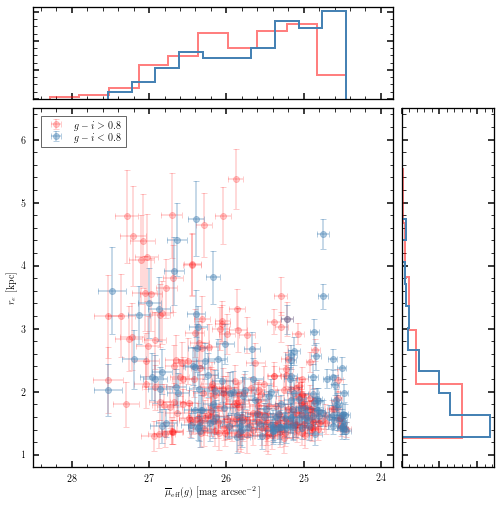

In [56]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1.8), height_ratios=(1.8, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.04, hspace=0.04)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (udg_cat['g-i'].data > 0.8)

ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', alpha=0.2, label='$g-i > 0.8$')

ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', alpha=0.4, label='$g-i < 0.8$')

leg = ax.legend(loc='upper left', frameon=True)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('dimgray')
leg.get_frame().set_boxstyle('Square', pad=0.)

ax.set_xlim(28.5, 23.85)
ax.set_ylim(0.8, 6.5)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histx.set_yticklabels([])
ax_histy.set_xticklabels([])
# ax_histy.set_xscale('log')

In [6]:
kz.set_matplotlib(style='default', usetex=False, dpi=60, fontsize=13)

Text(0.5, 0, '$d_{\\rm ang} / R_{\\rm vir, ang}$')

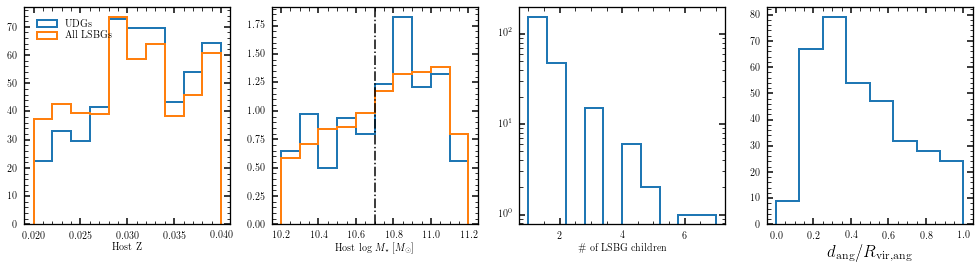

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{\rm ang} / R_{\rm vir, ang}$', fontsize=17)

(array([  3.,   7.,   9.,  26.,  30.,  44., 100.,  98.,  18.,   5.]),
 array([0.15702272, 0.26007967, 0.36313661, 0.46619356, 0.5692505 ,
        0.67230745, 0.7753644 , 0.87842134, 0.98147829, 1.08453523,
        1.18759218]),
 <BarContainer object of 10 artists>)

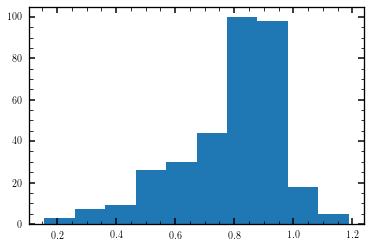

In [58]:
plt.hist(udg_cat['g-i'])

(array([13., 35., 87., 30., 25., 20., 32., 24., 34., 40.]),
 array([0.        , 0.08224507, 0.16449014, 0.24673521, 0.32898028,
        0.41122535, 0.49347042, 0.5757155 , 0.65796057, 0.74020564,
        0.82245071]),
 <BarContainer object of 10 artists>)

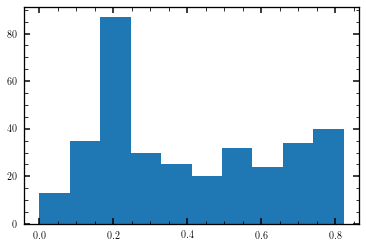

In [60]:
plt.hist(udg_cat['completeness'])

In [61]:
from scipy.stats import binned_statistic
quench_frac, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'].data > 0.7), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(np.nan_to_num(udg_cat['log_m_star'].data), (udg_cat['g-i'] > 0.7), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

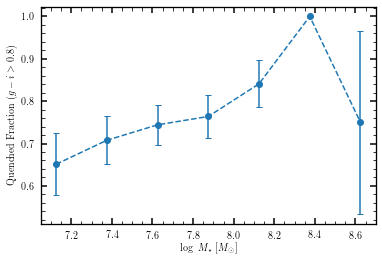

In [62]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

---